## Cosas ha hacer: ##
1. Integracion: 
    - Obtención de datos: OK
    - Explicación del dataset: OK
    - Resolver duplicidades e incosistencias. OK 
    - Resolver problemas de codificacion (unidades de medida Km, m). OK
2. Preprocesamiento:
    - Outliers: OK.
    - Valores faltantes: OK.
    - Normalizar: OK
    - Discr etizar
    - Selección/Reducción de variables.
    - Estandarizar
3. Modelo: (Conjunto Entrenamiento, Test y Validación)
    - KNN.
    - RegresOKión lógistica. (Filtros ruido TOMEK LINKS, CVCF)
    - Arboles OK pero sin filtros.
4. Evalución:  OKMetodologias dividir datos entrenamiento, validacion y test
    - Matriz de confusión. OK
    - Clasificacion precision predictiva(Usando Grid).
    - Error cuadratico medio.
5. Interpretación y difusión:
    - Usos del modelo.



## Proyecto Final
- Yeray Aller Errea
- Javier Aranguren Ortiz
### Resumen
El problema que vamos a abordar va ser el de clasificacion del dataset *seeds*. El problema se basa el la clasificacion de 3 tipos de semilla diferentes(Kama, Rosa, Canadian) segun 7 caracteristicas que tenemos sobre ellas. La resolucion de este problema puede tener aplicacion en la industria agricola  para identificar correctamente los diferentes tipos de semillas.

### Desarrollo
![Descripción KDD](KDD.jpg)  
Para este proyeto vamos a utilizar la metodología KDD, que se divide en la siguientes etapas
1. Integracion y recopilacion.
2. Preprocesamiento.
3. Modelado.
4. Evalución.
5. Disfusión.


## INTEGRACIÓN Y RECOPILACIÓN ##
### Dataset ###
Para ese proyecto hemos seleccionado el dataset [Seeds](https://www.kaggle.com/datasets/rwzhang/seeds-dataset).El conjunto de datos Seeds contiene siete atributos geométricos de granos de trigo y tres variedades de semillas.
- Área del grano **A**
- Perímetro del grano **P**
- Compacidad del grano **C** = 4 * pi * A / P^2
- Longitud del núcleo
- Ancho del núcleo
- Coeficiente de asimetría
- Longitud del surco del núcleo

Se compone de 3 clases diferentes las cuales representan 3 tipos de semillas.
- Kama
- Rosa
- Canadian

### Librerias ###
Para el siguiente proyecto hemos usado las siguientes librerias:
- pandas: Librería que permite analizar datos y manipularlos. En nuestro caso la usamos para leer y almacenar los datos de esta práctica.
- numpy: Librería que permite crear vectores multidimensinales y operaciones matematicas.
- sklearn: (scikit-learn): Librería que permite analizar datos, realizar predicciones...
- matplotlib: Librería que permite realizar diagramas.

In [38]:
##Importamos todas las librerias necesarias para la práctica
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

### Carga de datos
La información necesaria para este proyecto se encuentra seed_dataset.txt, la extraemos y la almacenamos.

In [2]:
# Lectura del archivo csv
seeds = pd.read_csv('seeds_dataset.txt', delim_whitespace=True, header=None)
# Asignamos los nombres de las columnas
feature_names = ['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel', 'asymmetry_coeff', 'length_kernel_groove']
class_names = ['Kama', 'Rosa', 'Canadian']
seeds.columns = ['area', 'perimetro', 'compacidad', 'longitud_nucleo', 'ancho_nucleo', 'coeficiente_asimetria', 'longitud_surco', 'class']
seeds

,area,perimetro,compacidad,longitud_nucleo,ancho_nucleo,coeficiente_asimetria,longitud_surco,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


En primer lugar mostramos un resumen estadístico de la información de las variables del dataset.

In [3]:
print(seeds.describe())

             area   perimetro  compacidad  longitud_nucleo  ancho_nucleo  \
count  210.000000  210.000000  210.000000       210.000000    210.000000   
mean    14.847524   14.559286    0.870999         5.628533      3.258605   
std      2.909699    1.305959    0.023629         0.443063      0.377714   
min     10.590000   12.410000    0.808100         4.899000      2.630000   
25%     12.270000   13.450000    0.856900         5.262250      2.944000   
50%     14.355000   14.320000    0.873450         5.523500      3.237000   
75%     17.305000   15.715000    0.887775         5.979750      3.561750   
max     21.180000   17.250000    0.918300         6.675000      4.033000   

       coeficiente_asimetria  longitud_surco       class  
count             210.000000      210.000000  210.000000  
mean                3.700201        5.408071    2.000000  
std                 1.503557        0.491480    0.818448  
min                 0.765100        4.519000    1.000000  
25%                 

## Preprocesamiento
Consiste en revisar los datos para asegurar su calidad, con el objetivo de que las técnicas de extracción de conocimiento obtengan mayor y mejor información.
Para ello realizamos los siguientes pasos/funciones.

### Inconsistencias
Revisamos el contenido del data frame anterior para comprobar que no haya incosistencias, dado que los unicos nombres donde podría existir inconsistencias son las clases, y estan estan discretizadas, no existe ningun problema de incosistencia en lo referente a los nombres.
Otra posible opción de inconsistencia puede ser las medidas, es decir, que todos los atributos perimetro, longitud, etc se encuentren en la misma medida, tras revisar estos, podemos observar que tienen valores similares, por lo que no es necesarios convertirlos.

### Limpieza de datos
Consideramos que no hay que realizar ningún cambio sobre el dataset, ya que los datos son válidos, y dado la corta cantidad de datos de la que se dispone no se pueden descartar datos, además no disponemos de ningún método para detectar errores, dado que no se puede comprobar su validez.

### Valores duplicados
Se debe comprobar que no existan valores duplicados, ya que estos datos afectan al resultado final sin aportar ninguna información extra.
En el caso de existir se eliminan, este ayuda a mejorar la eficiencia al tener menos datos con los que trabajar.

In [4]:
def esValoresDuplicados(dataset):
    if(dataset.duplicated().any()):
        print("\tValores duplicados")
        return True
    else:
        print("\tNo hay valores duplicados")
        return False

def tratarValoresDuplicados(dataset):
    dataset.drop_duplicates(inplace=True)
    print("\tSe han eliminado las filas con valores duplicados")

# Ejemplo con nuestro dataset
print("Ejemplo seeds")
if(esValoresDuplicados(seeds)):tratarValoresDuplicados(seeds)

# Ejemplo del caso no ejecutado
print("Ejemplo pruebas")
pruebas = pd.DataFrame({"a":[1,1,3,4],"b":[1,1,3,4],"c":[1,1,None,12]})
print(pruebas)
if(esValoresDuplicados(pruebas)):tratarValoresDuplicados(pruebas)
print(pruebas)


Ejemplo seeds
	No hay valores duplicados
Ejemplo pruebas
   a  b     c
0  1  1   1.0
1  1  1   1.0
2  3  3   NaN
3  4  4  12.0
	Valores duplicados
	Se han eliminado las filas con valores duplicados
   a  b     c
0  1  1   1.0
2  3  3   NaN
3  4  4  12.0


### Valores Faltantes
Es fundamental coprobar que no existan filas con valores vacios, y en el caso de que estos existan, se deben tratar.
Para ello se disponen de dos opciones, asignarles un valor o eliminar esta fila.
Para datsets grandes en los que existe una cantidad de información suficiente, se podrían eliminar las filas correspondientes.
En cambio en datasets más pequeños sustituir los valores es mejor opción sustituir los valores.
En nuestro caso al tener un dataset pequeño hemos decidido en caso de que fate un valor en la clase, directamente eliminarla ya que no se podria utilizar para entranarla y no se podria predecir.
En el caso de los atributos, en caso de faltar algun valor hemos decidido sutituirlo por la media de ese atributo.

In [5]:
def esValoresFaltantes(dataset):
    if(dataset.isnull().any().any()):
        return True
    else:
        return False

def tratarValoresFaltantes(dataset):
    if(dataset['class'].isnull().sum() != 0):
        dataset = dataset.dropna(subset=['class'])
        print("\tFaltan valores en los atributos")
    cols_con_valores_faltantes = dataset.columns[dataset.isnull().any()].tolist()
    preprocesamiento = ColumnTransformer(transformers=[('num', SimpleImputer(strategy='mean'), cols_con_valores_faltantes)])
    dataset = dataset.copy()
    dataset[cols_con_valores_faltantes] = preprocesamiento.fit_transform(dataset[cols_con_valores_faltantes])
    print("\tFaltan valores en la clase")
    return dataset


# Ejemplo con nuestro dataset
print("Ejemplo seeds")
if(esValoresFaltantes(seeds)):
    seeds = tratarValoresFaltantes(seeds)

# Ejemplo del caso no ejecutado
print("Ejemplo pruebas")
pruebas = pd.DataFrame({"class":[1,2,3,4],"b":[5,6,7,8],"c":[9,10,11,12]})
print(pruebas)
if(esValoresFaltantes(pruebas)):
    pruebas = tratarValoresFaltantes(pruebas)
print(pruebas)

Ejemplo seeds
Ejemplo pruebas
   class  b   c
0      1  5   9
1      2  6  10
2      3  7  11
3      4  8  12
   class  b   c
0      1  5   9
1      2  6  10
2      3  7  11
3      4  8  12


Generamos dos DataFrames: uno para la información de entrada (X) y otro para la de salida (y)

In [6]:
X = seeds.iloc[:, :-1]
y = seeds.iloc[:, -1]

A continuación vamos a dividir los ejemplos en train, validación y test utilizando Hold-out con estratificación y el valor 42 como semilla.

- Conjunto de entrenamiento: Utilizado para aprender los parámetros de los modelos para una determinada configuración de los valores de los híper-parámetros del mismo.
- Conjunto de validación: Utilizado para determinar los mejores valores de los híper-parámetros de los modelos.
- Conjunto de test: Utilizado para ver la calidad del mejor modelo obtenido en los pasos anteriores.
- Estratificacion: Se utiliza para que cada subconjunto tenga la misma proporción de cada clase que el conjunto de datos original.
- Semilla: se utiliza para la asignación de un valor aleatorio fijo para la división de los datos.

Vamos a dividir los conjuntos en un 10% test, 80% entrenamiento y el restante validacion.

In [7]:
X_resto, X_test, y_resto, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_resto, y_resto, test_size=0.2, stratify=y_resto, random_state=42)

### Outliers
Son los valores del atributo que son considerablemente distintos al resto de valores del mismo atributo, existen distintas maneras de detectarlos, ya sea por la media o por los cuartiles.
Se pueden tratar de distintas formas, desde ignorarlos, cambiarlos o eliminarlos.  
En nuestro caso usamos los cuartiles para detectar los outliers, para ello elejimos un valor k de 1.5, que implica que la detección sea más restrictiva.
Además, en nuestro caso sustituimos los valores outliers por la mediana de la variable correspondiente.

In [8]:
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
            self.stats = X.describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calula el IQR de cada variable
        IQRs = self.stats.loc['75%'] - self.stats.loc['25%']
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['25%'] - self.k * IQRs
        limiteSup = self.stats.loc['75%'] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = (X < limiteInf)
        mayores = (X > limiteSup)
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = np.logical_or(menores[c], mayores[c])
            # Si hay outliers
            if indices.any():
                # Los sustituimos por la mediana
                Xaux.loc[indices,c] = self.stats.loc['50%',c]
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

In [9]:
out_IQR = OutlierDetecion_treatment_IQR()
X_train_IQR = out_IQR.fit_transform(X_train)
if(X_train.equals(X_train_IQR)):
   print("No se han encontrado outliers")
else:
   print("Se han encontrado outliers y el dataframe ha sido modificado")
   X_train = X_train_IQR

Se han encontrado outliers y el dataframe ha sido modificado


## MODELOS

Ahora vamos a utilizar diferentes tecnicas de clasificacion para evaluar sus rendimientos.

### KNN
El algoritmo K vecinos más cercanos permite clasificar un valor a partir de sus k vecinos más cercanos, los vecinos votan con su clase, y la clase con más votos es la predicción del valor.
Para nuestra ejecución tenemos en cuenta tres parametros:
- n_neighbors: Número de vecinos a analizar, conocido como K, este parametro indica cuantos vecinos se van a tener en cuenta, estos se cogen de más cerca a más lejos, hasta que se alcanza el número k de vecinos.  
- weight: Pesos de los vecinos que se tienen en cuenta para decidir que clase se le otorga al elemento a clasificar:
    - uniform: Les da a todos los vecinos el mismo peso.
    - distance: Da más valor a los vecinos cuya distancia sea menor al valor a clasificar.
- p: Parámetro de potencia para la métrica de distancia. 
    - p=1: se utiliza la distancia de Manhattan. 
    - p=2: se utiliza la distancia euclidiana.
    - p=otro: se utiliza la métrica de distancia Minkowski.

In [10]:
# Modelo
knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# Entrenamiento
knn.fit(X_train, y_train)

# Predicciones
prediccion_train_knn = knn.predict(X_train)
prediccion_val_knn = knn.predict(X_val)
prediccion_test_knn = knn.predict(X_test)

# Train
accuracy_train_knn = accuracy_score(y_train, prediccion_train_knn)
precision_train_knn = precision_score(y_train, prediccion_train_knn, average='macro') * 100
recall_train_knn = recall_score(y_train, prediccion_train_knn, average='macro') * 100
f1_train_knn = f1_score(y_train, prediccion_train_knn, average='macro') * 100

# Validacion
accuracy_val_knn = accuracy_score(y_val, prediccion_val_knn)
precision_val_knn = precision_score(y_val, prediccion_val_knn, average='macro') * 100
recall_val_knn = recall_score(y_val, prediccion_val_knn, average='macro') * 100
f1_val_knn = f1_score(y_val, prediccion_val_knn, average='macro') * 100

# Test
accuracy_test_knn = accuracy_score(y_test, prediccion_test_knn)
precision_test_knn = precision_score(y_test, prediccion_test_knn, average='macro') * 100
recall_test_knn = recall_score(y_test, prediccion_test_knn, average='macro') * 100
f1_test_knn = f1_score(y_test, prediccion_test_knn, average='macro') * 100

# Resultados
print("Resultados train:")
print("Accuracy train: {:.2f}%".format(accuracy_train_knn * 100))
print("Precisión train: {:.2f}%".format(precision_train_knn))
print("Recall train: {:.2f}%".format(recall_train_knn))
print("F1 train: {:.2f}%".format(f1_train_knn))
print("Error train: {:.2f}%".format((1-accuracy_train_knn) * 100))

print("\nResultados validacion:")
print("Accuracy validacion: {:.2f}%".format(accuracy_val_knn * 100))
print("Precisión validacion: {:.2f}%".format(precision_val_knn))
print("Recall validacion: {:.2f}%".format(recall_val_knn))
print("F1 validacion: {:.2f}%".format(f1_val_knn))
print("Error validacion: {:.2f}%".format((1-accuracy_val_knn) * 100))

print("\nResultados test:")
print("Accuracy test: {:.2f}%".format(accuracy_test_knn * 100))
print("Precisión test: {:.2f}%".format(precision_test_knn))
print("Recall test: {:.2f}%".format(recall_test_knn))
print("F1 test: {:.2f}%".format(f1_test_knn))
print("Error test: {:.2f}%".format((1-accuracy_test_knn) * 100))

Resultados train:
Accuracy train: 96.03%
Precisión train: 96.29%
Recall train: 96.01%
F1 train: 96.07%
Error train: 3.97%

Resultados validacion:
Accuracy validacion: 84.21%
Precisión validacion: 84.82%
Recall validacion: 83.55%
F1 validacion: 82.85%
Error validacion: 15.79%

Resultados test:
Accuracy test: 90.48%
Precisión test: 91.67%
Recall test: 90.48%
F1 test: 90.00%
Error test: 9.52%


In [11]:
# Usamos un grid para obtener el mejor modelo
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2, 1.5, 3]
}

# Modelo
grid_KNN = GridSearchCV(knn, param_grid, cv=5)

# Entrenamiento
grid_KNN.fit(X_train, y_train)

# Mejor estimador
print("Mejor estimador: ", grid_KNN.best_params_)
best_estimator = grid_KNN.best_estimator_

# Predicciones
prediccion_train_knn = best_estimator.predict(X_train)
prediccion_val_knn = best_estimator.predict(X_val)
prediccion_test_knn = best_estimator.predict(X_test)

# Train
accuracy_train_knn = accuracy_score(y_train, prediccion_train_knn)
precision_train_knn = precision_score(y_train, prediccion_train_knn, average='macro') * 100
recall_train_knn = recall_score(y_train, prediccion_train_knn, average='macro') * 100
f1_train_knn = f1_score(y_train, prediccion_train_knn, average='macro') * 100

# Validacion
accuracy_val_knn = accuracy_score(y_val, prediccion_val_knn)
precision_val_knn = precision_score(y_val, prediccion_val_knn, average='macro') * 100
recall_val_knn = recall_score(y_val, prediccion_val_knn, average='macro') * 100
f1_val_knn = f1_score(y_val, prediccion_val_knn, average='macro') * 100

# Test
accuracy_test_knn = accuracy_score(y_test, prediccion_test_knn)
precision_test_knn = precision_score(y_test, prediccion_test_knn, average='macro') * 100
recall_test_knn = recall_score(y_test, prediccion_test_knn, average='macro') * 100
f1_test_knn = f1_score(y_test, prediccion_test_knn, average='macro') * 100

# Resultados
print("\nResultados train:")
print("Accuracy train: {:.2f}%".format(accuracy_train_knn * 100))
print("Precisión train: {:.2f}%".format(precision_train_knn))
print("Recall train: {:.2f}%".format(recall_train_knn))
print("F1 train: {:.2f}%".format(f1_train_knn))
print("Error train: {:.2f}%".format((1-accuracy_train_knn) * 100))

print("\nResultados validacion:")
print("Accuracy validacion: {:.2f}%".format(accuracy_val_knn * 100))
print("Precisión validacion: {:.2f}%".format(precision_val_knn))
print("Recall validacion: {:.2f}%".format(recall_val_knn))
print("F1 validacion: {:.2f}%".format(f1_val_knn))
print("Error validacion: {:.2f}%".format((1-accuracy_val_knn) * 100))

print("\nResultados test:")
print("Accuracy test: {:.2f}%".format(accuracy_test_knn * 100))
print("Precisión test: {:.2f}%".format(precision_test_knn))
print("Recall test: {:.2f}%".format(recall_test_knn))
print("F1 test: {:.2f}%".format(f1_test_knn))
print("Error test: {:.2f}%".format((1-accuracy_test_knn) * 100))

Mejor estimador:  {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}

Resultados train:
Accuracy train: 100.00%
Precisión train: 100.00%
Recall train: 100.00%
F1 train: 100.00%
Error train: 0.00%

Resultados validacion:
Accuracy validacion: 81.58%
Precisión validacion: 81.16%
Recall validacion: 80.98%
F1 validacion: 80.42%
Error validacion: 18.42%

Resultados test:
Accuracy test: 95.24%
Precisión test: 95.83%
Recall test: 95.24%
F1 test: 95.21%
Error test: 4.76%


### Regresion logística

La regresión logística permite clasificar un valor usando una función logística, su resultado es una probabilidad de pertenecer a una clase determinada, es recomendable para problemas de clasificación binarios (solo con dos clases), en nuestro caso, al tener tres clases para clasificar, se le proporciona un parámetro que indica que hay más de dos clases.
- C: regularización entre ajustar los valores de entrenamiento y mantener los coeficientes del modelo pequeños (REV)
- multi_class: Sirve para el caso en el que se tienen más de dos clases.
     - "ovr": One-vs-Rest crea un clasificador para cada clase, la clase con la puntuación más alta es la elegida.
- solver: Algoritmo que se usa para optimizar el modelo.
    - "liblinear"


In [12]:
# Modelo
lr = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(multi_class="ovr"))])

# Entrenamiento
lr.fit(X_train, y_train)

# Predicciones
prediccion_train_lr = lr.predict(X_train)
prediccion_val_lr = lr.predict(X_val)
prediccion_test_lr = lr.predict(X_test)

# Train
accuracy_train_lr = accuracy_score(y_train, prediccion_train_lr) * 100
precision_train_lr = precision_score(y_train, prediccion_train_lr, average='macro') * 100
recall_train_lr = recall_score(y_train, prediccion_train_lr, average='macro') * 100
f1_train_lr = f1_score(y_train, prediccion_train_lr, average='macro') * 100
error_train_lr = mean_squared_error(y_train, prediccion_train_lr, squared=False)


# Validacion
accuracy_val_lr = accuracy_score(y_val, prediccion_val_lr) * 100
precision_val_lr = precision_score(y_val, prediccion_val_lr, average='macro') * 100
recall_val_lr = recall_score(y_val, prediccion_val_lr, average='macro') * 100
f1_val_lr = f1_score(y_val, prediccion_val_lr, average='macro') * 100
error_val_lr = mean_squared_error(y_val, prediccion_val_lr, squared=False)

# Test
accuracy_test_lr = accuracy_score(y_test, prediccion_test_lr)
precision_test_lr = precision_score(y_test, prediccion_test_lr, average='macro') * 100
recall_test_lr = recall_score(y_test, prediccion_test_lr, average='macro') * 100
f1_test_lr = f1_score(y_test, prediccion_test_lr, average='macro') * 100
error_test_lr = mean_squared_error(y_test, prediccion_test_lr, squared=False)

# Resultados
print("Resultados train:")
print("Accuracy train: {:.2f}%".format(accuracy_train_lr))
print("Precisión train: {:.2f}%".format(precision_train_lr))
print("Recall train: {:.2f}%".format(recall_train_lr))
print("F1 train: {:.2f}%".format(f1_train_lr))
print("Error cuadratico medio train: ", error_train_lr)

print("\nResultados validacion:")
print("Accuracy validacion: {:.2f}%".format(accuracy_val_lr))
print("Precisión validacion: {:.2f}%".format(precision_val_lr))
print("Recall validacion: {:.2f}%".format(recall_val_lr))
print("F1 validacion: {:.2f}%".format(f1_val_lr))
print("Error cuadratico medio validacion: ", error_val_lr)

print("\nResultados test:")
print("Accuracy test: {:.2f}%".format(accuracy_test_lr * 100))
print("Precisión test: {:.2f}%".format(precision_test_lr))
print("Recall test: {:.2f}%".format(recall_test_lr))
print("F1 test: {:.2f}%".format(f1_test_lr))
print("Error cuadratico medio validacion: ", error_test_lr)


Resultados train:
Accuracy train: 95.36%
Precisión train: 95.36%
Recall train: 95.39%
F1 train: 95.37%
Error cuadratico medio train:  0.35472216532031997

Resultados validacion:
Accuracy validacion: 84.21%
Precisión validacion: 84.72%
Recall validacion: 83.55%
F1 validacion: 82.86%
Error cuadratico medio validacion:  0.6882472016116853

Resultados test:
Accuracy test: 95.24%
Precisión test: 95.83%
Recall test: 95.24%
F1 test: 95.21%
Error cuadratico medio validacion:  0.21821789023599236


### Precision-Recall (PR) ###

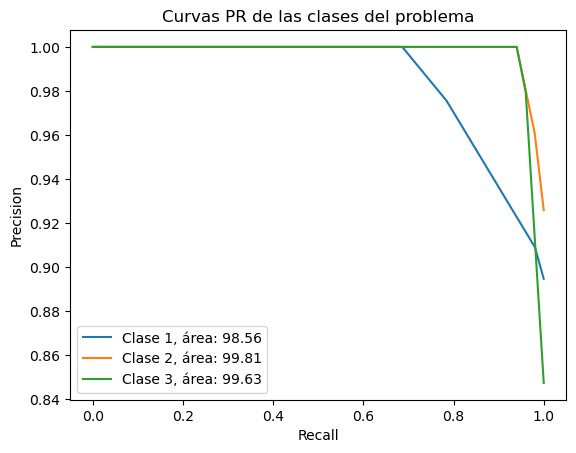

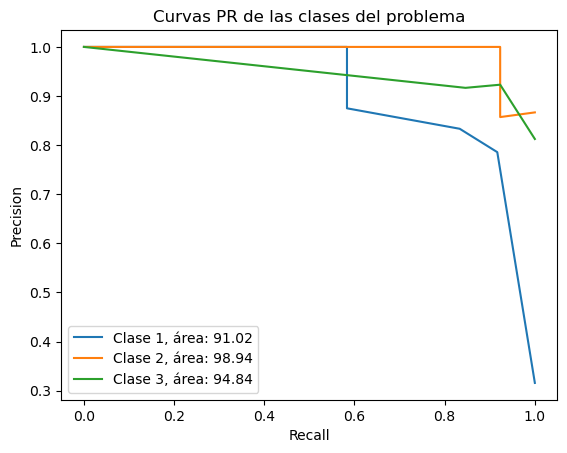

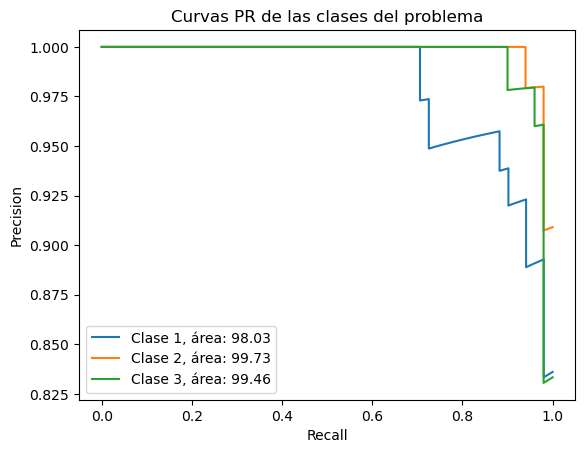

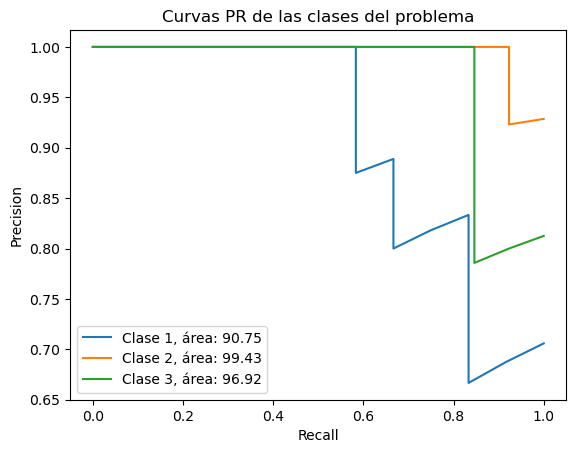

In [13]:
# Función que muestra la curva PR para cada clase del problema para un clasificador (clf) y unos datos de entrada (X) y salida (y)
def muestra_PR_courve_clases(clf, X, y):
    # Obtenemos la lista de clases diferentes (únicas)
    clasesUnicas = np.unique(y)
    # Para cada clase única
    for i,clase in enumerate(clasesUnicas):
        # predecimos las probabilidades de predecir cada ejemplo en la clase del bucle
        model_probs = clf.predict_proba(X)[:, i]
        # calculamos todos los pares de puntos (precision, recall) que componen la curva PR de esa clase
        # (método precision_recall_curve pasando las clases reales, las probabilidades de la clase y la clase en concreto, pos_label)
        model_precision, model_recall, _ = precision_recall_curve(y == clase, model_probs, pos_label=1)
        # Calculamos el área bajo la curva PR (método auc) para la clase del bucle en tanto por 100
        model_auc_PR_clase = auc(model_recall, model_precision) * 100
        # Creamos la etiqueta para poner como leyenda de la figura a cada clase
        etiqueta = 'Clase '+ str(clase) + ', área: ' + str(round(model_auc_PR_clase, 2))
        # Mostramos la curva en la figura (plot) y le ponemos la etiqueta
        plt.plot(model_recall, model_precision, label=etiqueta)
    # Etiquetas de los ejes
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # Leyenda
    plt.legend()
    # Título
    plt.title('Curvas PR de las clases del problema')
    # Mostramos la figura
    plt.show()

muestra_PR_courve_clases(knn, X_train, y_train)
muestra_PR_courve_clases(knn, X_val, y_val)
muestra_PR_courve_clases(lr, X_train, y_train)
muestra_PR_courve_clases(lr, X_val, y_val)

### Arboles de decision
Es un clasificador que como indica su nombre, imita el comportamiento de un árbol, en concreto, la división de sus ramas hasta llegas a las hojas, su estructura se divide en dos partes, nodos y en hojas.
- Hojas: Corresponde a la clase
- Nodos: Nodo de decisión que contiene una comprobación que le indica por que descendiente debe seguir
En nuestro caso para trabajar con árboles vamos a usar los siguientes parámetros:
- criterion: Separación de los nodos del árbol.
    - "gini": CART
    - "entropy": C4.5
- max_depth: Profundidad máxima del árbol.
- min_samples_split: Número mínimo de elementos necesario para que se produzca una nueva división en el nodo.
- min_samples_leaf: Número mínimo de elementos necesario para que un nodo se considere hoja.

In [14]:
listaAccTrain = []
listaAccTest = []
for tipoArbol in ['gini','entropy']:
    tree = DecisionTreeClassifier(criterion=tipoArbol, random_state=123)
    tree.fit(X_train, y_train)
    prediccion_tree = tree.predict(X_train)
    accuracy = accuracy_score(y_train, prediccion_tree)
    listaAccTrain.append(accuracy * 100)
    prediccion_tree = tree.predict(X_test)
    accuracy = accuracy_score(y_test, prediccion_tree)
    listaAccTest.append(accuracy * 100)
print('Rendimiento CART en train: ', listaAccTrain[0])
print('Rendimiento CART en test: ', listaAccTest[0])
print('Rendimiento c4.5 en train: ', listaAccTrain[1])
print('Rendimiento C4.5 en test: ', listaAccTest[1])

Rendimiento CART en train:  100.0
Rendimiento CART en test:  95.23809523809523
Rendimiento c4.5 en train:  100.0
Rendimiento C4.5 en test:  95.23809523809523


Como podemos observar los arboles clasifican todos los ejemplos de entrenamiento correctamente. Esto se debe a que los arboles de decision tienden a sobre entrenar, por lo tanto pueden ser muy complicados para las características de los ejemplos de entrenamiento.
Para solucionar esto vamos utilizar tecnicas de pre-poda, de este modo obtendremos arboles mas sencillos que se ajusten mas a los datos de entrenamiento.

Para ello vamos a utilizar los híper-parámetros *min_samples_split* y *min_samples_leaf* utilizando las siguientes configuraciones:

- criterion = 'gini', min_samples_split = 2, min_samples_leaf = 1
- criterion = 'gini', min_samples_split = 6, min_samples_leaf = 3
- criterion = 'gini', min_samples_split = 10, min_samples_leaf = 5
- criterion = 'entropy', min_samples_split = 2, min_samples_leaf = 1
- criterion = 'entropy', min_samples_split = 6, min_samples_leaf = 3
- criterion = 'entropy', min_samples_split = 10, min_samples_leaf = 5

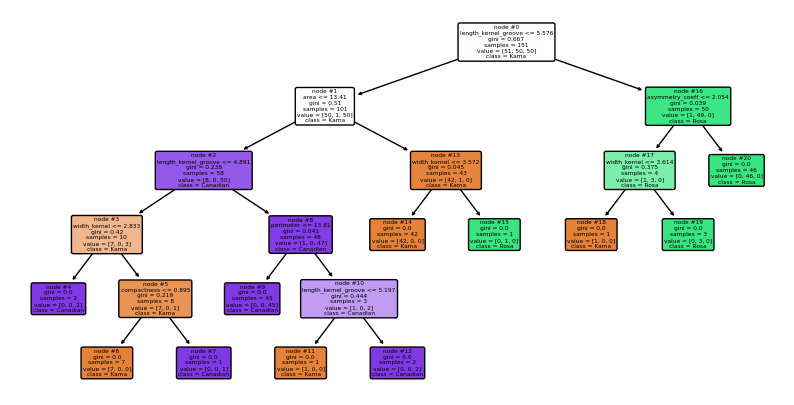

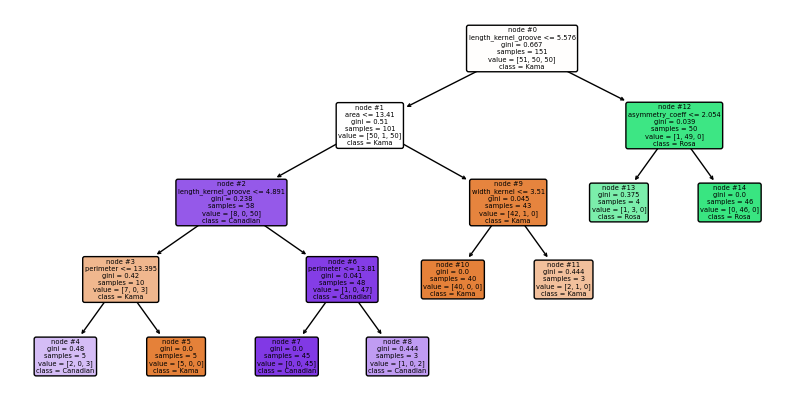

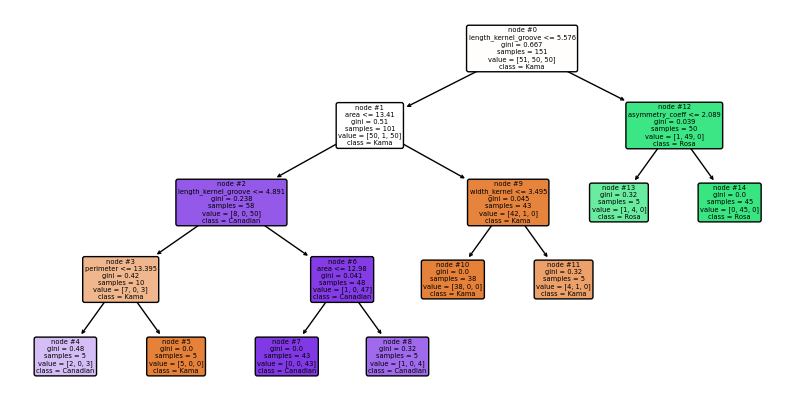

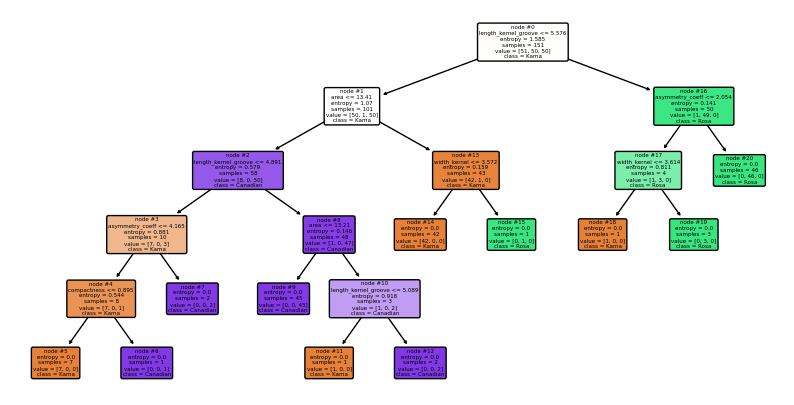

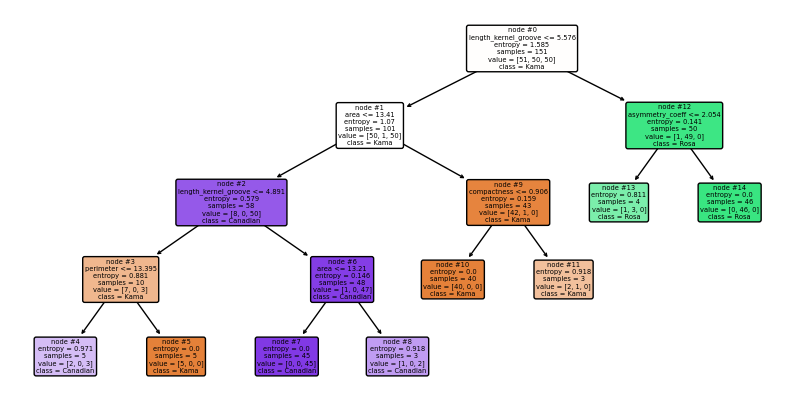

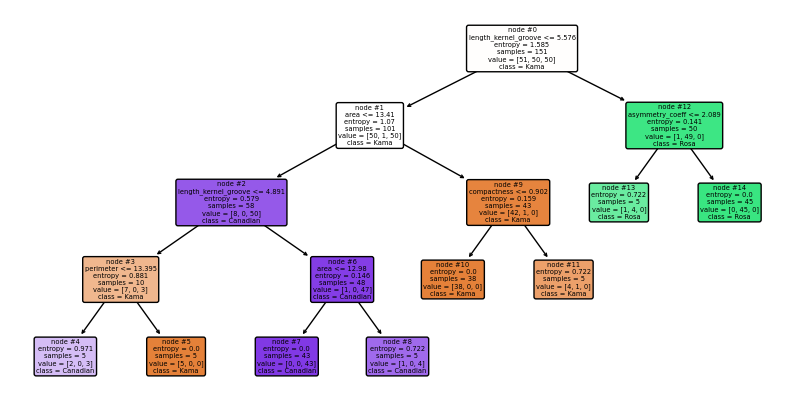

In [15]:
configs = [{'criterion': 'gini', 'min_samples_split': 2, 'min_samples_leaf': 1},
           {'criterion': 'gini', 'min_samples_split': 6, 'min_samples_leaf': 3},
           {'criterion': 'gini', 'min_samples_split': 10, 'min_samples_leaf': 5},
           {'criterion': 'entropy', 'min_samples_split': 2, 'min_samples_leaf': 1},
           {'criterion': 'entropy', 'min_samples_split': 6, 'min_samples_leaf': 3},
           {'criterion': 'entropy', 'min_samples_split': 10, 'min_samples_leaf': 5}]

for i, config in enumerate(configs):
    # Llamada al constructor del árbol de decisión con la configuración apropiada
    clasificador = DecisionTreeClassifier(criterion=config['criterion'], min_samples_split=config['min_samples_split'], min_samples_leaf=config['min_samples_leaf'])
    # Entrenamiento del árbol de decisión
    clasificador = clasificador.fit(X_train, y_train)
    # Mostramos el árbol de decisión en una figura usando el método plot_tree de la clase tree
    fig = plt.figure(figsize=(10,5))
    plot_tree(clasificador, feature_names=feature_names, class_names=class_names, filled=True, rounded=True, node_ids=True)
    # Establecemos el nombre del fichero donde guardamos la figura
    nombreFicheroSalida = 'arbol' + str(i) + '.png'
    # Guardamos la figura en un archivo png
    fig.savefig(nombreFicheroSalida)

## Evaluación

### Matriz de Confusión ###
Es una herramienta de clasificación que permite evaluar el rendimiento de problemas de clasificación.
Tenemos los siguientes parámetros:
- True Positive (TP): Elementos clasificados correctamente como positivos.
- True Negative (TN): Elementos clasificados correctamente como negativos.
- False Positive (FP): Elementos clasificados errorneamente como positivos.
- False Negative (FN): Elementos clasificados erroneamente como negativos.

Creamos una funcion que sirva para crear matrizes de confusion

In [16]:
def obtenerMatrizConfusion(clasificador, X, y, labels):
    predicciones = clasificador.predict(X)
    return confusion_matrix(y, predicciones, labels=labels)

Realizamos la matriz de confusion para todos los metodos con los datos de entrenamiento

In [17]:
# Matriz de confusion
mc3 = np.array([["   ","P_1","P_2","P_3"],["C_1","TP1","FN1","FN1"],["C_2","FP2","TP2","FN2"],["C_3","FP3","FP3","TP3"]])
print(mc3)
# KNN con train
matrizConfusionKNN_train = obtenerMatrizConfusion(knn, X_train, y_train, labels=[1,2,3])
print("Matriz de confusión KNN con los valores de TRAIN:")
print(matrizConfusionKNN_train)

# Regresion con train
matrizConfusionLR_train = obtenerMatrizConfusion(lr, X_train, y_train, labels=[1,2,3])
print("Matriz de confusión regresion con los valores de TRAIN:")
print(matrizConfusionLR_train)

# Arbol de decision con train
matrizConfusionArbolDecision_train = obtenerMatrizConfusion(tree, X_train, y_train, labels=[1,2,3])
print("Matriz de confusión arbol de decision con los valores de TRAIN:")
print(matrizConfusionArbolDecision_train)

[['   ' 'P_1' 'P_2' 'P_3']
 ['C_1' 'TP1' 'FN1' 'FN1']
 ['C_2' 'FP2' 'TP2' 'FN2']
 ['C_3' 'FP3' 'FP3' 'TP3']]
Matriz de confusión KNN con los valores de TRAIN:
[[50  0  1]
 [ 3 47  0]
 [ 2  0 48]]
Matriz de confusión regresion con los valores de TRAIN:
[[47  2  2]
 [ 1 49  0]
 [ 2  0 48]]
Matriz de confusión arbol de decision con los valores de TRAIN:
[[51  0  0]
 [ 0 50  0]
 [ 0  0 50]]


Realizamos la matriz de confusion para todos los metodos con los datos de test

In [55]:
# Matriz de confusion
mc3 = np.array([["   ","P_1","P_2","P_3"],["C_1","TP1","FN1","FN1"],["C_2","FP2","TP2","FN2"],["C_3","FP3","FP3","TP3"]])
print(mc3)
# KNN con test
matrizConfusionKNN_test = obtenerMatrizConfusion(knn, X_test, y_test, labels=[1,2,3])
print("Matriz de confusión KNN con los valores de TEST:")
print(matrizConfusionKNN_test)

# Regresion con test
matrizConfusionRegresion_test = obtenerMatrizConfusion(lr, X_test, y_test, labels=[1,2,3])
print("Matriz de confusión regresión con los valores de TEST:")
print(matrizConfusionRegresion_test)

# Arbol de decision con test
matrizConfusionArbolDecision_test = obtenerMatrizConfusion(tree, X_test, y_test, labels=[1,2,3])
print("Matriz de confusión arbol de decisión con los valores de TEST:")
print(matrizConfusionArbolDecision_test)

[['   ' 'P_1' 'P_2' 'P_3']
 ['C_1' 'TP1' 'FN1' 'FN1']
 ['C_2' 'FP2' 'TP2' 'FN2']
 ['C_3' 'FP3' 'FP3' 'TP3']]
Matriz de confusión KNN con los valores de TEST:
[[5 1 1]
 [0 7 0]
 [0 0 7]]
Matriz de confusión regresión con los valores de TEST:
[[6 1 0]
 [0 7 0]
 [0 0 7]]
Matriz de confusión arbol de decisión con los valores de TEST:
[[6 0 1]
 [0 7 0]
 [0 0 7]]


### Medidas de rendimiento
A partir de la matriz de confusión podemos obtener las siguiente métricas para evaluar:
- Recall/True positive rate (TPR) = TP/(TP+FN): Aciertos al clasificar positivamente, se calcula sobre el total de todas las muestras positivas. 
- Precision = TP/(TP+FP): Mide el número de clasificaciones positivas correctas  respecto a el número de clasificaciones positivas total.
- F1 score = 2 * ((Precision * Recall)/(Precision + recall)): Combina recall y precisión.
- Accuracy = (TP+TN)/(TP+TN+FP+FN): Proporción de clasificaciones correctas.

In [53]:
def evalua_clasificador_metricas_individuales(clasificador, X, y):
    predicciones = clasificador.predict(X)
    tpr = recall_score(y, predicciones, pos_label=1, average="weighted") 
    precision = precision_score(y, predicciones, pos_label=1, average="weighted") 
    F1 = 2*((precision*tpr)/(precision+tpr))
    
    return tpr * 100, precision * 100, F1 * 100

In [54]:
recall_knn,  precision_knn, f1_knn = evalua_clasificador_metricas_individuales(knn, X_test, y_test)
print("KNN:\n\tRecall: {}%\n\tPrecision: {}%\n\tF1: {}%".format(round(recall_knn,2), round(precision_knn,2), round(f1_knn, 2)))
recall_tree,  precision_tree, f1_tree = evalua_clasificador_metricas_individuales(tree, X_test, y_test)
print("Árbol decisión:\n\tRecall: {}%\n\tPrecision: {}%\n\tF1: {}%".format(round(recall_tree,2), round(precision_tree,2), round(f1_tree, 2)))
recall_lr,  precision_lr, f1_lr = evalua_clasificador_metricas_individuales(lr, X_test, y_test)
print("Regresión logistica:\n\tRecall: {}%\n\tPrecision: {}%\n\tF1: {}%".format(round(recall_lr,2), round(precision_lr,2), round(f1_lr, 2)))

KNN:
	Recall: 90.48%
	Precision: 91.67%
	F1: 91.07%
Árbol decisión:
	Recall: 95.24%
	Precision: 95.83%
	F1: 95.53%
Regresión logistica:
	Recall: 95.24%
	Precision: 95.83%
	F1: 95.53%


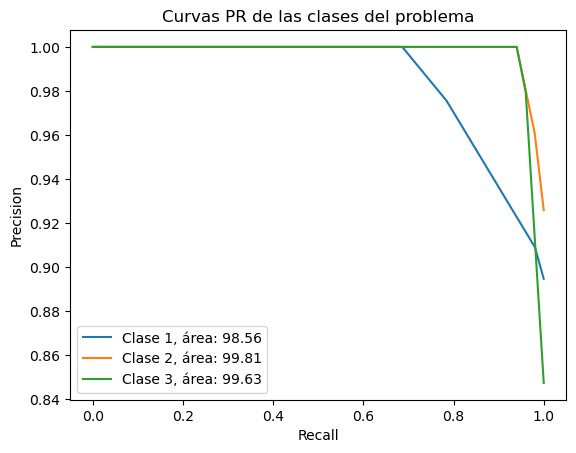

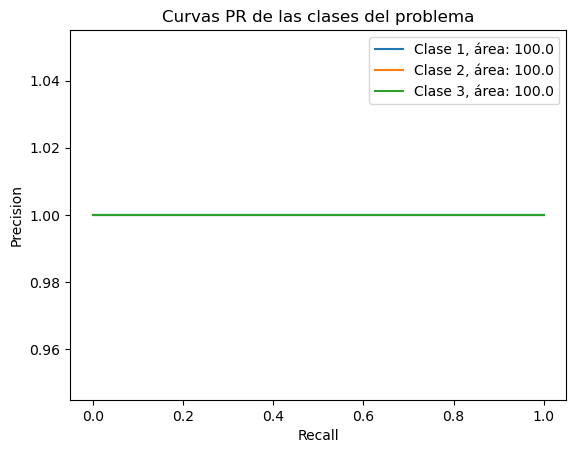

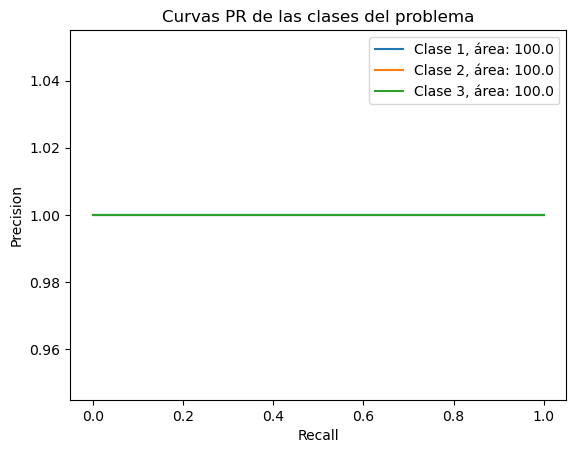

In [36]:
# Función que muestra la curva PR para cada clase del problema para un clasificador (clf) y unos datos de entrada (X) y salida (y)
def muestra_PR_courve_clases(clf, X, y):
    # Obtenemos la lista de clases diferentes (únicas)
    clasesUnicas = np.unique(y)
    # Para cada clase única
    for i,clase in enumerate(clasesUnicas):
        # predecimos las probabilidades de predecir cada ejemplo en la clase del bucle
        model_probs = clf.predict_proba(X)[:, i]
        # calculamos todos los pares de puntos (precision, recall) que componen la curva PR de esa clase
        # (método precision_recall_curve pasando las clases reales, las probabilidades de la clase y la clase en concreto, pos_label)
        model_precision, model_recall, _ = precision_recall_curve(y == clase, model_probs, pos_label=1)
        # Calculamos el área bajo la curva PR (método auc) para la clase del bucle en tanto por 100
        model_auc_PR_clase = auc(model_recall, model_precision) * 100
        # Creamos la etiqueta para poner como leyenda de la figura a cada clase
        etiqueta = 'Clase '+ str(clase) + ', área: ' + str(round(model_auc_PR_clase, 2))
        # Mostramos la curva en la figura (plot) y le ponemos la etiqueta
        plt.plot(model_recall, model_precision, label=etiqueta)
    # Etiquetas de los ejes
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # Leyenda
    plt.legend()
    # Título
    plt.title('Curvas PR de las clases del problema')
    # Mostramos la figura
    plt.show()

muestra_PR_courve_clases(knn, X_train, y_train)
muestra_PR_courve_clases(tree, X_train, y_train)
muestra_PR_courve_clases(lr, X_test, y_test)

### Grid
El uso de grids permite evaluar varios estimadores y parametros a la vez, con el fin de compararlos o almacenarlos, dado que el grid por si mismo no permite usar mas de un estimador, creamos una funcion a la que se le proporcionan la lista de estimadores y lista de parametros a analizar, ademas de la lista de atributos disponibles y la clase a la que corresponde cada conjunto de atributos.
La función devuelve el mejor estimador y los mejores parametros para este en funcion de los valores X e y proporcionados.

In [101]:
def mejorEstimador(estimador, parametros, X_train, y_train):
    mejor_puntuacion = 0
    mejor_estimador = None
    mejor_parametro = {}

    # Recorro todos los estimadores buscando cual es el mejor
    for nombre, estimador in estimadores:
        # Creo el grid
        grid_search = GridSearchCV(estimator=estimador, param_grid=parametros[nombre], cv=5)
        
        # Entreno el grid
        grid_search.fit(X_train, y_train)
        
        # Muestro los mejores parametros y la mejor puntuacion
        print("Estimador: {}".format(nombre))
        print("\tMejor puntuación: {}%".format(round(grid_search.best_score_*100,2)))
        print("\tMejores parametros: {}".format(grid_search.best_params_))
        
        # Almaceno la mejor puntuacion y los mejores parametros
        if grid_search.best_score_> mejor_puntuacion:
            mejor_estimador = nombre
            mejor_puntuacion = grid_search.best_score_
            mejor_parametro = grid_search.best_params_

    # Muestro la mejor puntacion y el mejor parametro
    print("\nRESULTADO FINAL")
    print("\tMejor estimador: {}".format(mejor_estimador))
    print("\tMejor puntuación: {}%".format(round(mejor_puntuacion*100,2)))
    print("\tMejore parametros: {}".format(mejor_parametro))
    return mejor_estimador, mejor_puntuacion, mejor_parametro

# Prueba
estimadores = [
    ("KNN", KNeighborsClassifier()),
    ("Arbol decision", DecisionTreeClassifier()),
    ("Regresion logistica", LogisticRegression(multi_class="ovr"))
]

parametros = {
    "KNN":{
        "n_neighbors": [1,3,5,7,9],
        "weights": ["uniform", "distance"],
        'p': [1, 2, 1.5, 3]
    },
    "Arbol decision":{
        "max_depth": [3,5,7,None],
        "criterion": ["gini","entropy"],
        "min_samples_split": [2,6,10],
        "min_samples_leaf": [1,3,5],
        'ccp_alpha': [0.001, 0.002, 0.003]
    },
    "Regresion logistica":{
        "solver": ["liblinear"]
    }
}

mejorEstimador(estimadores, parametros, X_train, y_train);


Estimador: KNN
	Mejor puntuación: 94.06%
	Mejores parametros: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Estimador: Arbol decision
	Mejor puntuación: 94.73%
	Mejores parametros: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10}
Estimador: Regresion logistica
	Mejor puntuación: 92.73%
	Mejores parametros: {'solver': 'liblinear'}

RESULTADO FINAL
	Mejor estimador: Arbol decision
	Mejor puntuación: 94.73%
	Mejore parametros: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10}
